# Visualize Model Weights

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

from common.binning import BIN_LABELS
from common.data import get_model_weights
from common.wisc import WISC_LEVEL

## Get weights

In [2]:
model = 'ridge'
population = 'adhd'
labels = BIN_LABELS if population == 'adhd' else BIN_LABELS[:1]
model_weights = {k: None for k in labels}

for bin_label in labels:
    bin_weights = {k: None for k in WISC_LEVEL[5]}
    
    for target in WISC_LEVEL[5]:
        weight = get_model_weights(model, population, target, bin_label)
        bin_weights[target] = weight
        
    model_weights[bin_label] = bin_weights

print(model_weights.keys(), model_weights['All']['WISC_FSIQ'].shape)

dict_keys(['All', 'Bin 1', 'Bin 2', 'Bin 3']) (34716,)


In [3]:
def round_to_sig_fig(value, sig_figs=1):
    value_str = np.format_float_positional(value, precision=sig_figs, unique=False, fractional=False, trim='k')
    return float(value_str)

In [6]:
cbar_max_pos = {k: 0 for k in WISC_LEVEL[5]}
cbar_max_neg = {k: 0 for k in WISC_LEVEL[5]}

for target in WISC_LEVEL[5]:
    target_max_pos, target_max_neg = [], []
    
    for bin_label in labels:
        fc_vector = to_power_network_fc_vector(model_weights[bin_label][target])
        target_max_pos.append(np.max(fc_vector))
        target_max_neg.append(np.min(fc_vector))
    
    cbar_max_pos[target] = round_to_sig_fig(np.max(target_max_pos))
    cbar_max_neg[target] = round_to_sig_fig(np.abs(np.min(target_max_neg)))
    
print(cbar_max_pos.items())
print(cbar_max_neg.items())

dict_items([('WISC_FSIQ', 0.008), ('WISC_VSI', 0.008), ('WISC_VCI', 0.006), ('WISC_FRI', 0.008), ('WISC_WMI', 0.01), ('WISC_PSI', 0.009)])
dict_items([('WISC_FSIQ', 0.006), ('WISC_VSI', 0.005), ('WISC_VCI', 0.006), ('WISC_FRI', 0.005), ('WISC_WMI', 0.005), ('WISC_PSI', 0.008)])


In [50]:
# Visualize FC instead of model weights
from common.data import get_data
from common.paths import HEALTHY, ADHD
from common.binning import bin_data

X, _, demographics, population = get_data(wisc_level=5, label_path=ADHD)
ages = demographics['Age']

X_bins, _, bin_labels = bin_data(X, ages, ages, True, 3)
X_bins_mean = np.array([np.mean(X_bin, axis=0) for X_bin in X_bins])

print(X_bins_mean.shape)

(4, 34716)


## Manipulate weights

### Filter weights by network

In [61]:
from common.data import filter_data_by_network
from common.power_atlas import POWER_NETWORKS

network = 'DMN'

for bin_label in BIN_LABELS:
    for target in WISC_LEVEL[5]:
        weight = model_weights[bin_label][target].reshape(1, -1)
        filtered_weight = filter_data_by_network(weight, POWER_NETWORKS[network], True, True)
        model_weights[bin_label][target] = filtered_weight[0]

print(model_weights.keys(), model_weights['Bin 1']['WISC_FSIQ'].shape)

dict_keys(['All', 'Bin 1', 'Bin 2', 'Bin 3']) (34716,)


### Raw weights

In [59]:
selected_target = "WISC_FRI"
age_group = 'Bin 2'

selected_features = model_weights[age_group][selected_target]
print(np.min(selected_features), np.max(selected_features))

-0.017775016 0.017262904


### Difference weights

In [135]:
selected_target = "WISC_WMI"
first_bin, second_bin = 'Bin 2', 'Bin 1'
age_group = f'{first_bin} - {second_bin}'

selected_features = model_weights[first_bin][selected_target] - model_weights[second_bin][selected_target]
# selected_features = np.abs(selected_features)
print(selected_features.shape, np.min(selected_features), np.max(selected_features))

(34716,) -0.025167085 0.024705455


### Functional Connectivity

In [59]:
selected_target = 'FC'
age_group = 'Bin 3'

selected_features = X_bins_mean[np.where(bin_labels == age_group)][0]
print(selected_features.shape, np.min(selected_features), np.max(selected_features))

(34716,) -0.14356826 0.8759837


## Plot glass brain

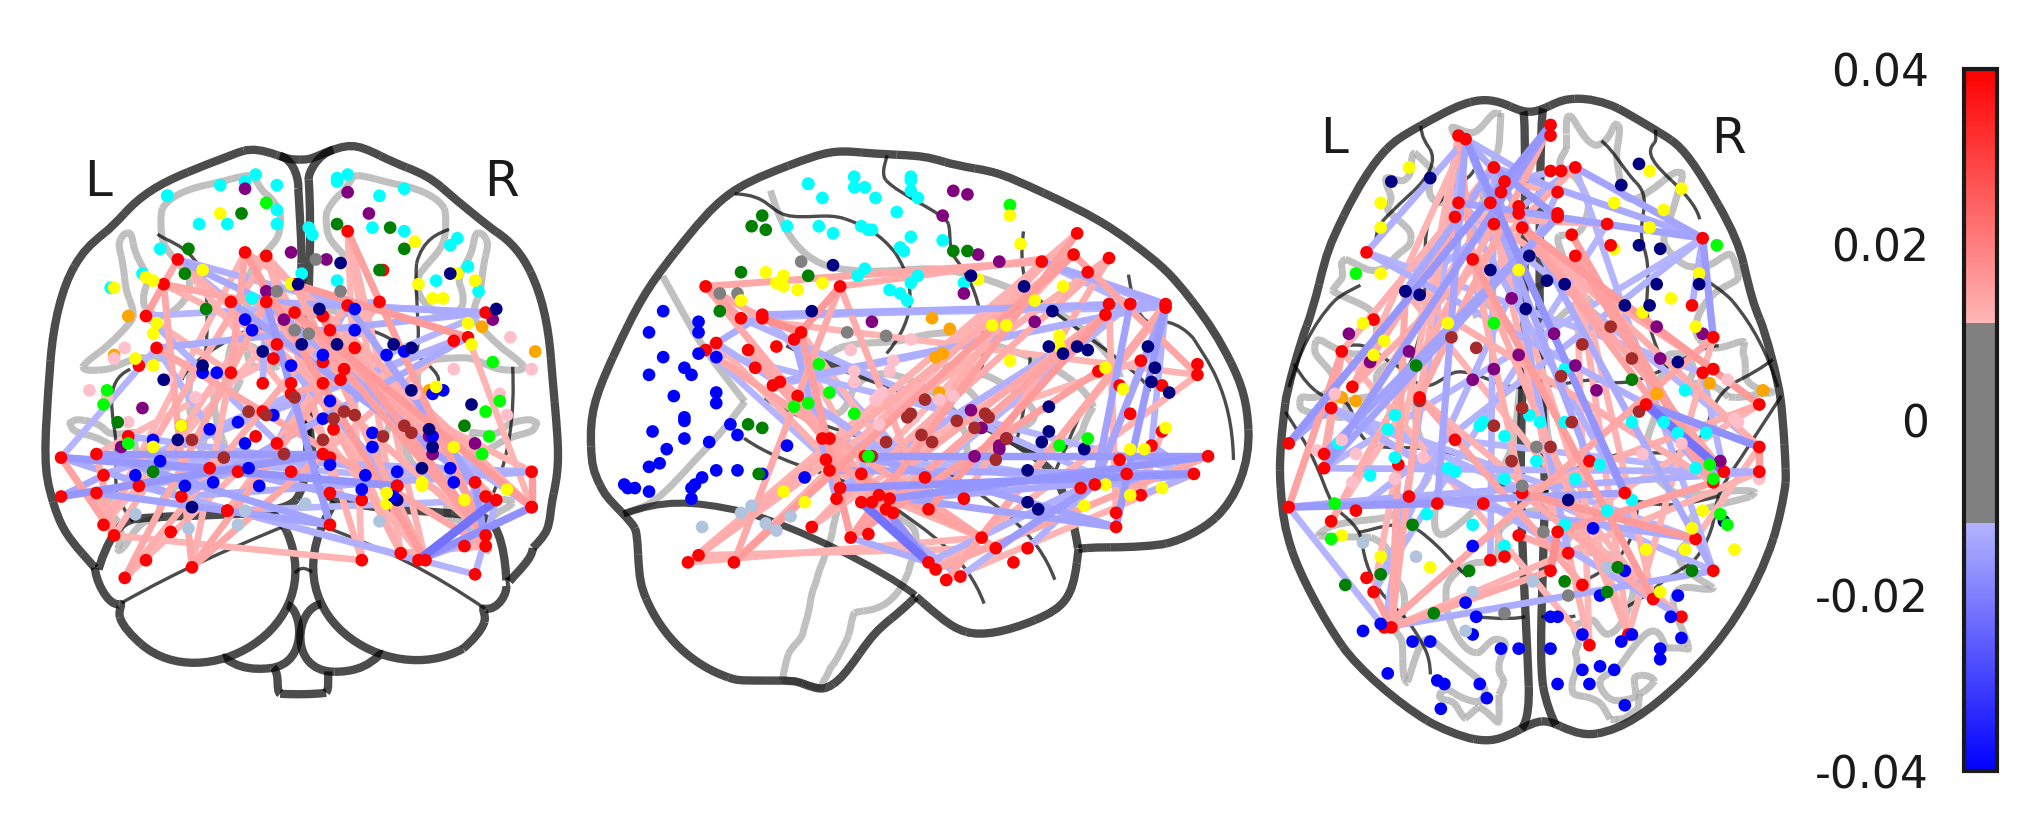

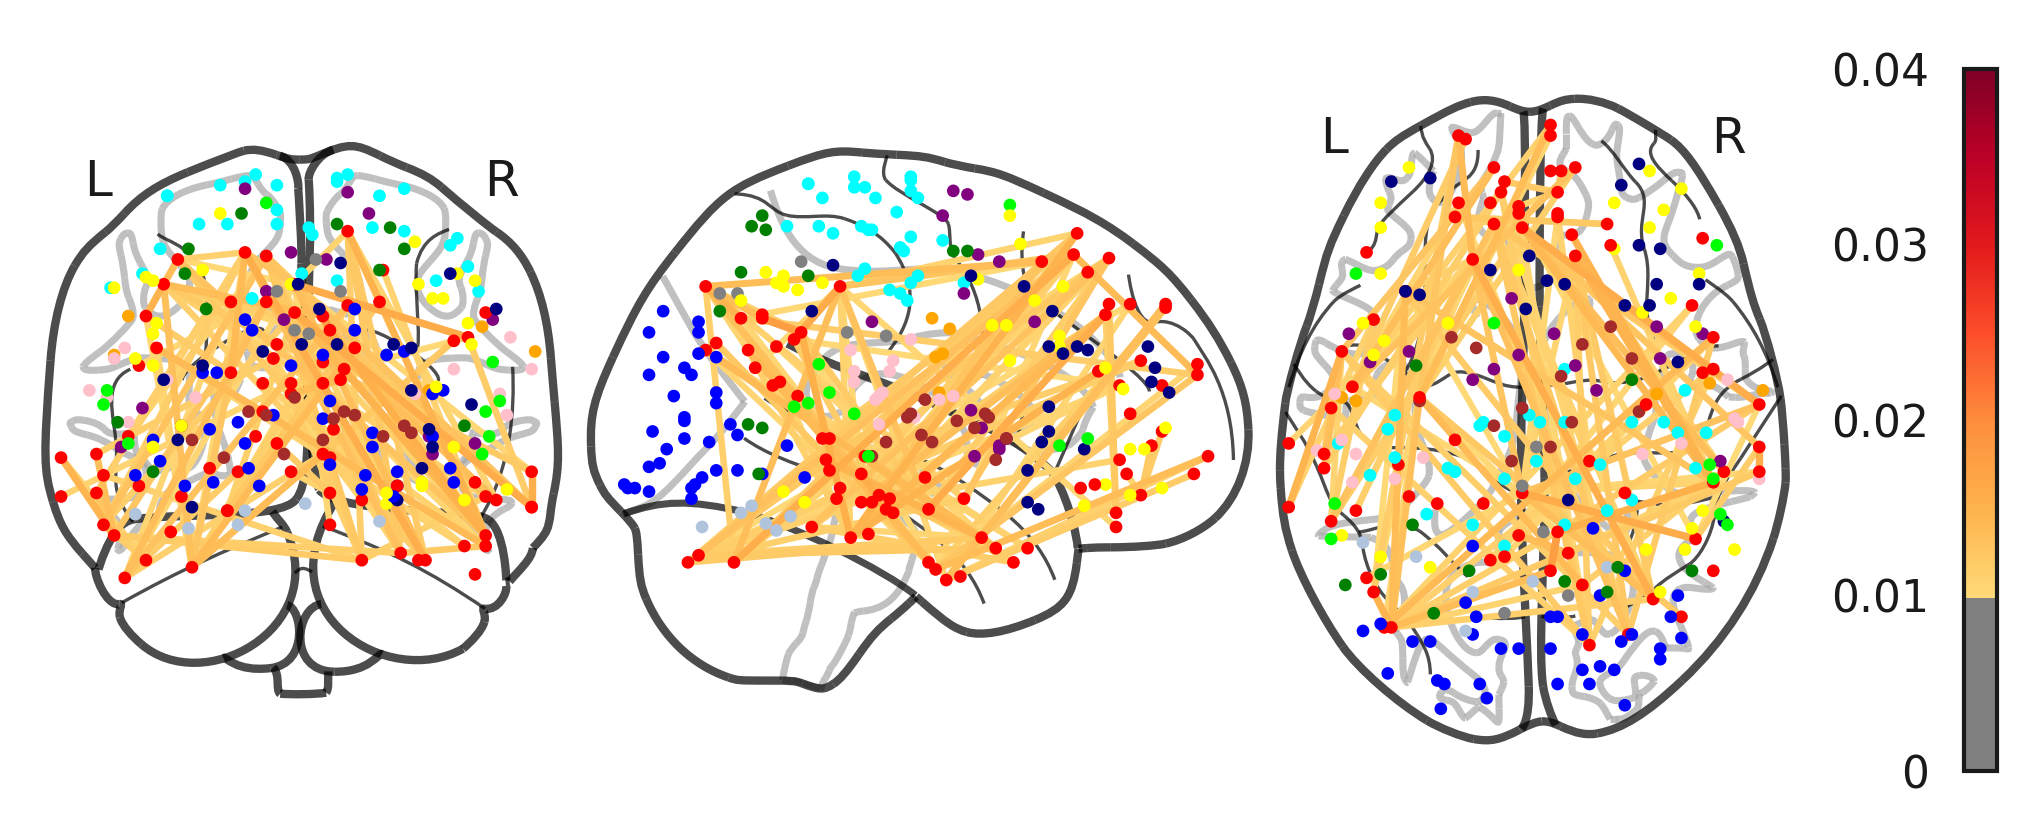

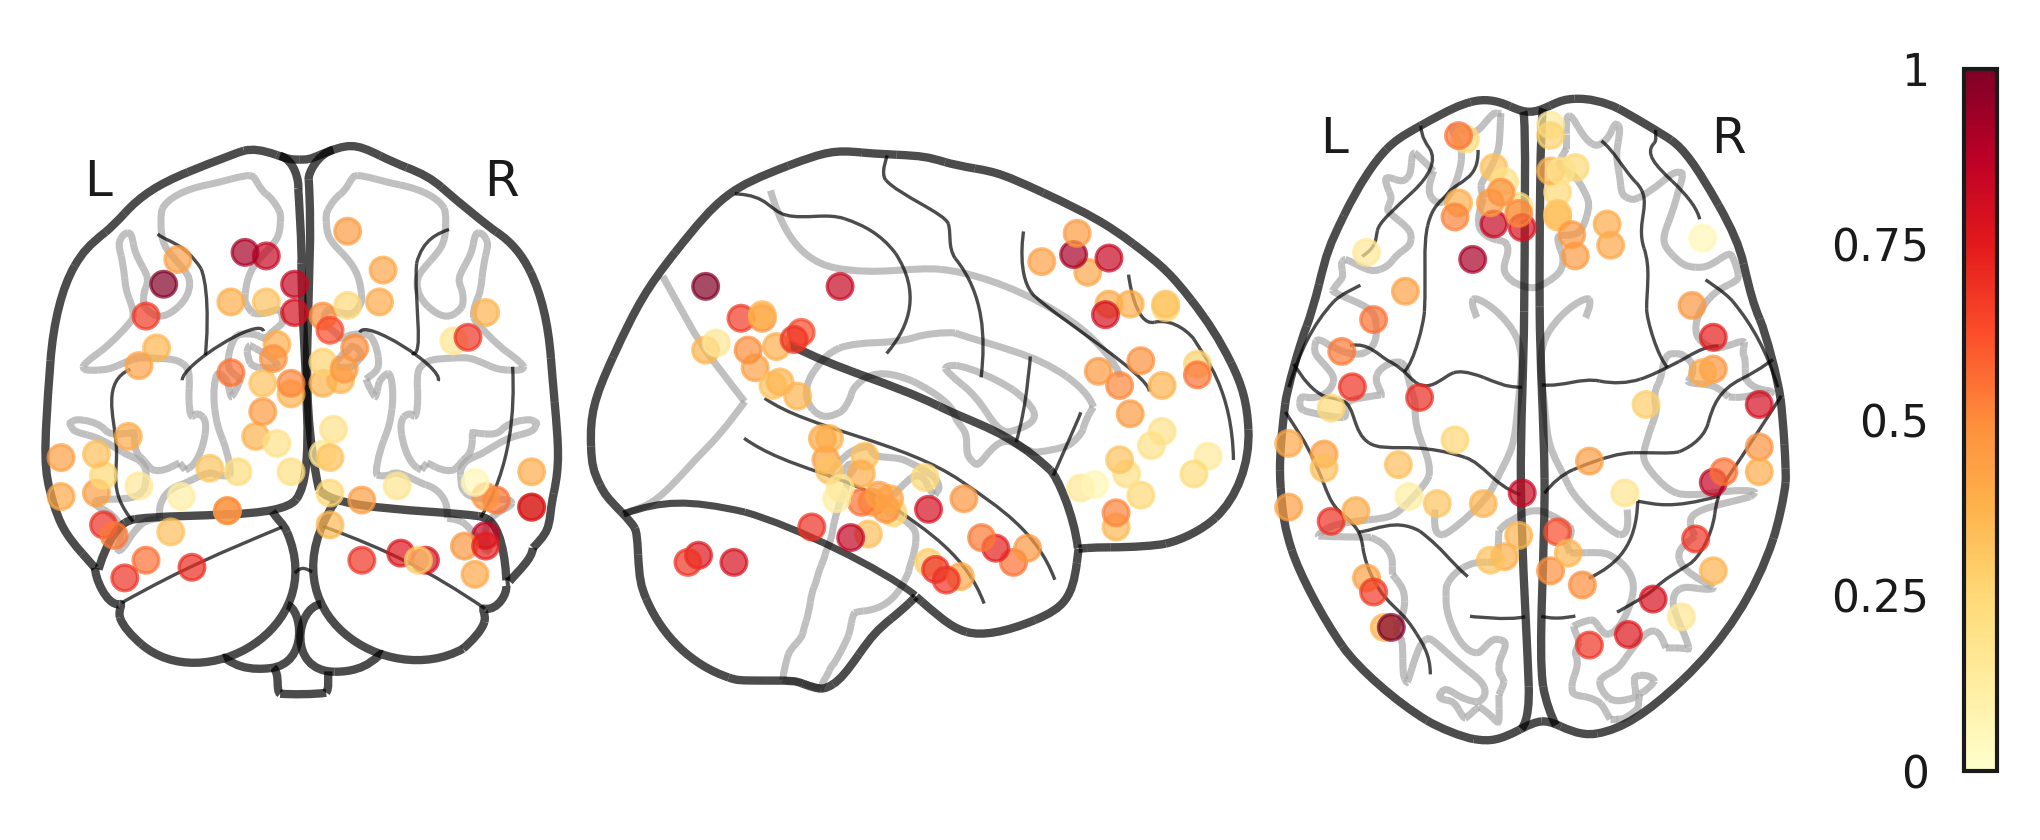

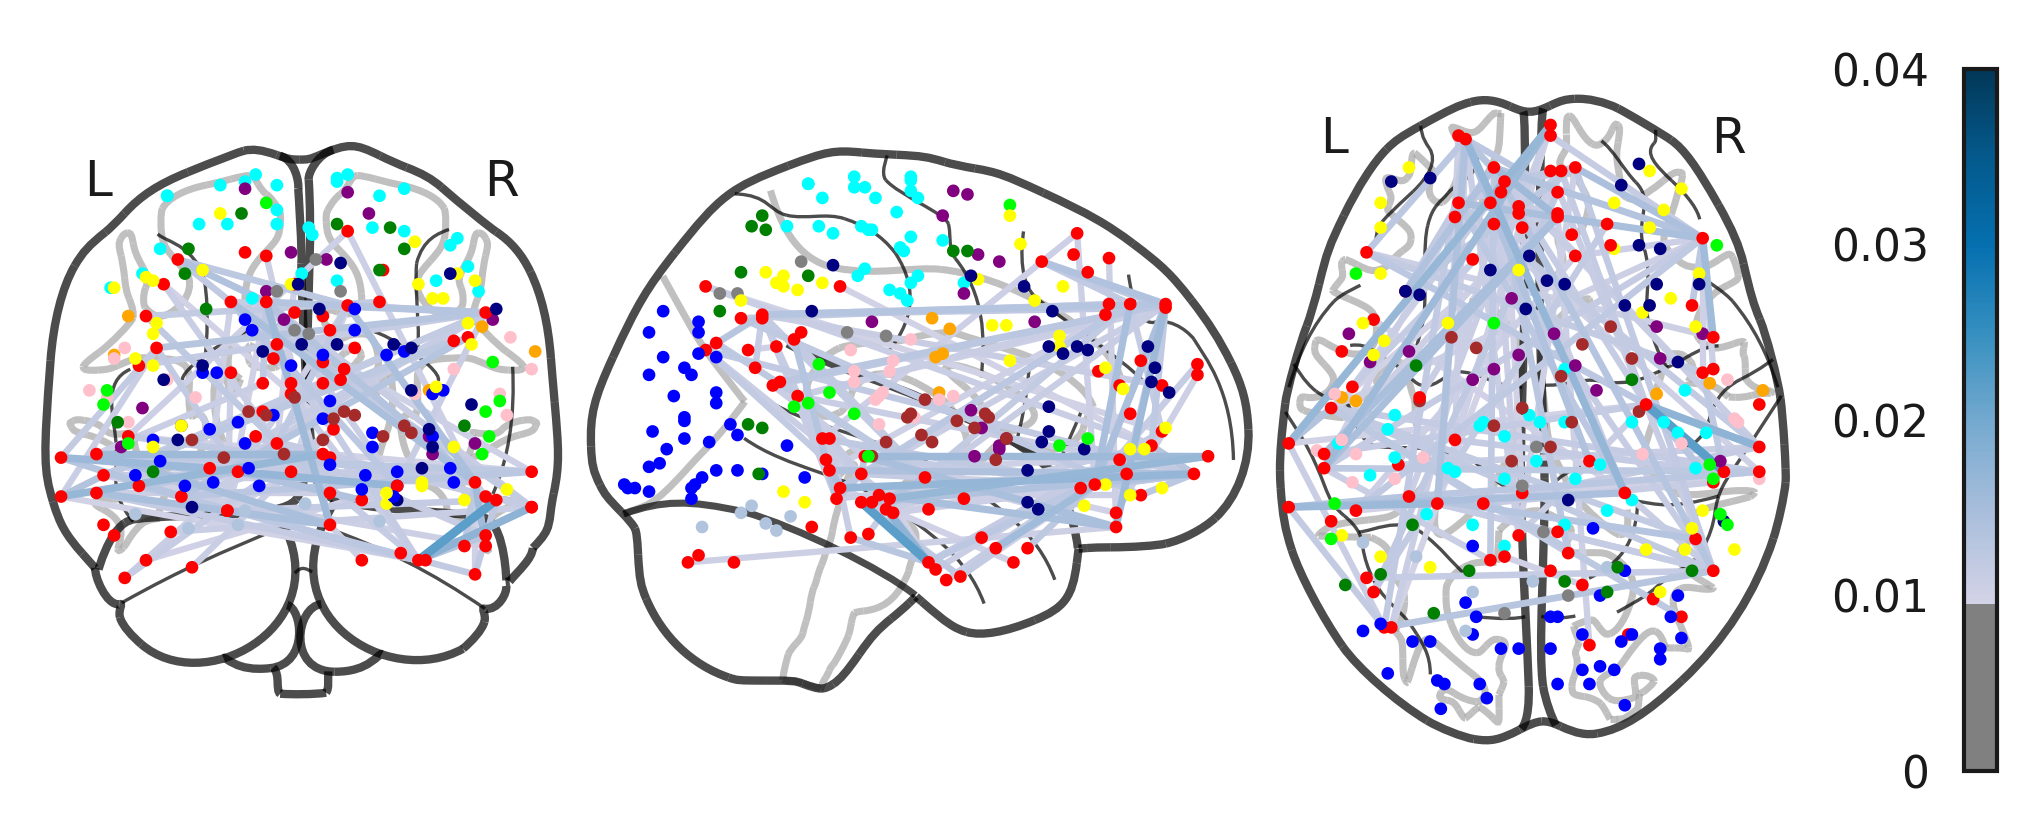

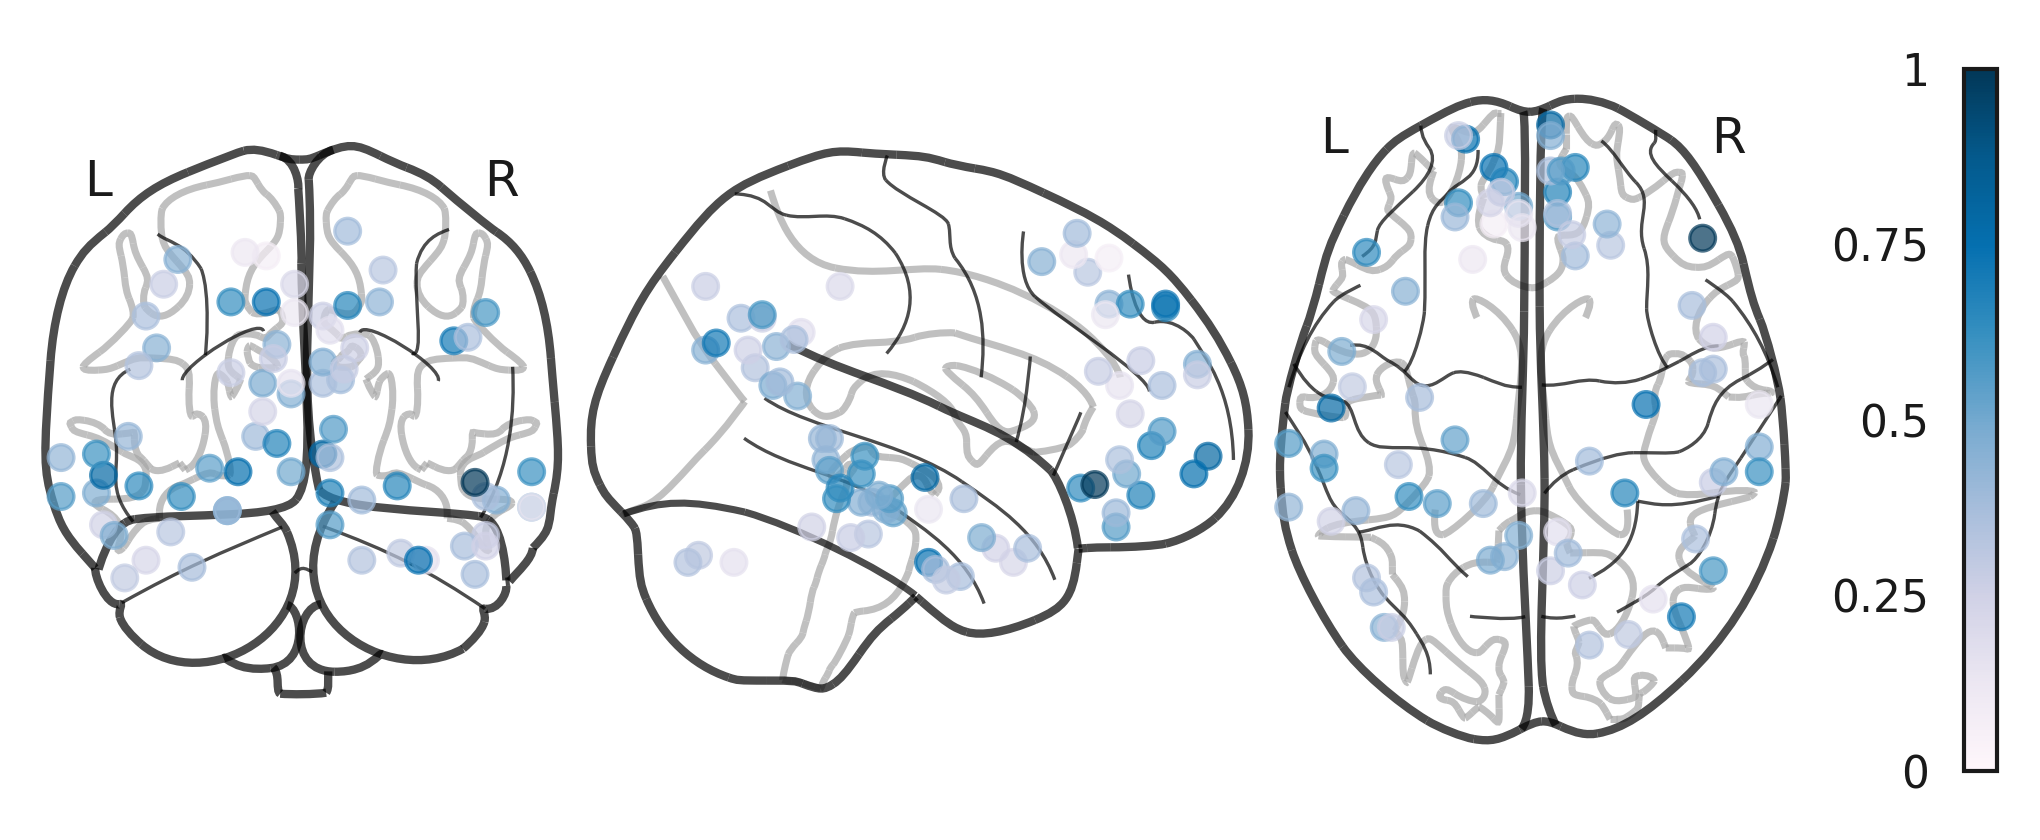

In [63]:
from common.plotting import plot_connections

plot_connections(selected_features, -0.04, 0.04, '99.7%', False, True, False)

## Plot connectivity circle (all edges)

In [4]:
from common.power_atlas import POWER_LABELS, to_power_fc_matrix, get_power_mpl_legend
from mne.viz import circular_layout, plot_connectivity_circle

In [16]:
node_order = POWER_LABELS.sort_values(by=['Assignment', 'ROI']).index
node_order = node_order.astype('str').to_list()

node_colors = POWER_LABELS['Color'].values.tolist()

num_nodes_per_system = POWER_LABELS['System'].value_counts().sort_index()
group_boundaries = np.array(np.cumsum(num_nodes_per_system.values)[:-1])

node_angles = circular_layout(POWER_LABELS.index.astype('str').to_list(), node_order, 
                              group_boundaries=group_boundaries, group_sep=0)

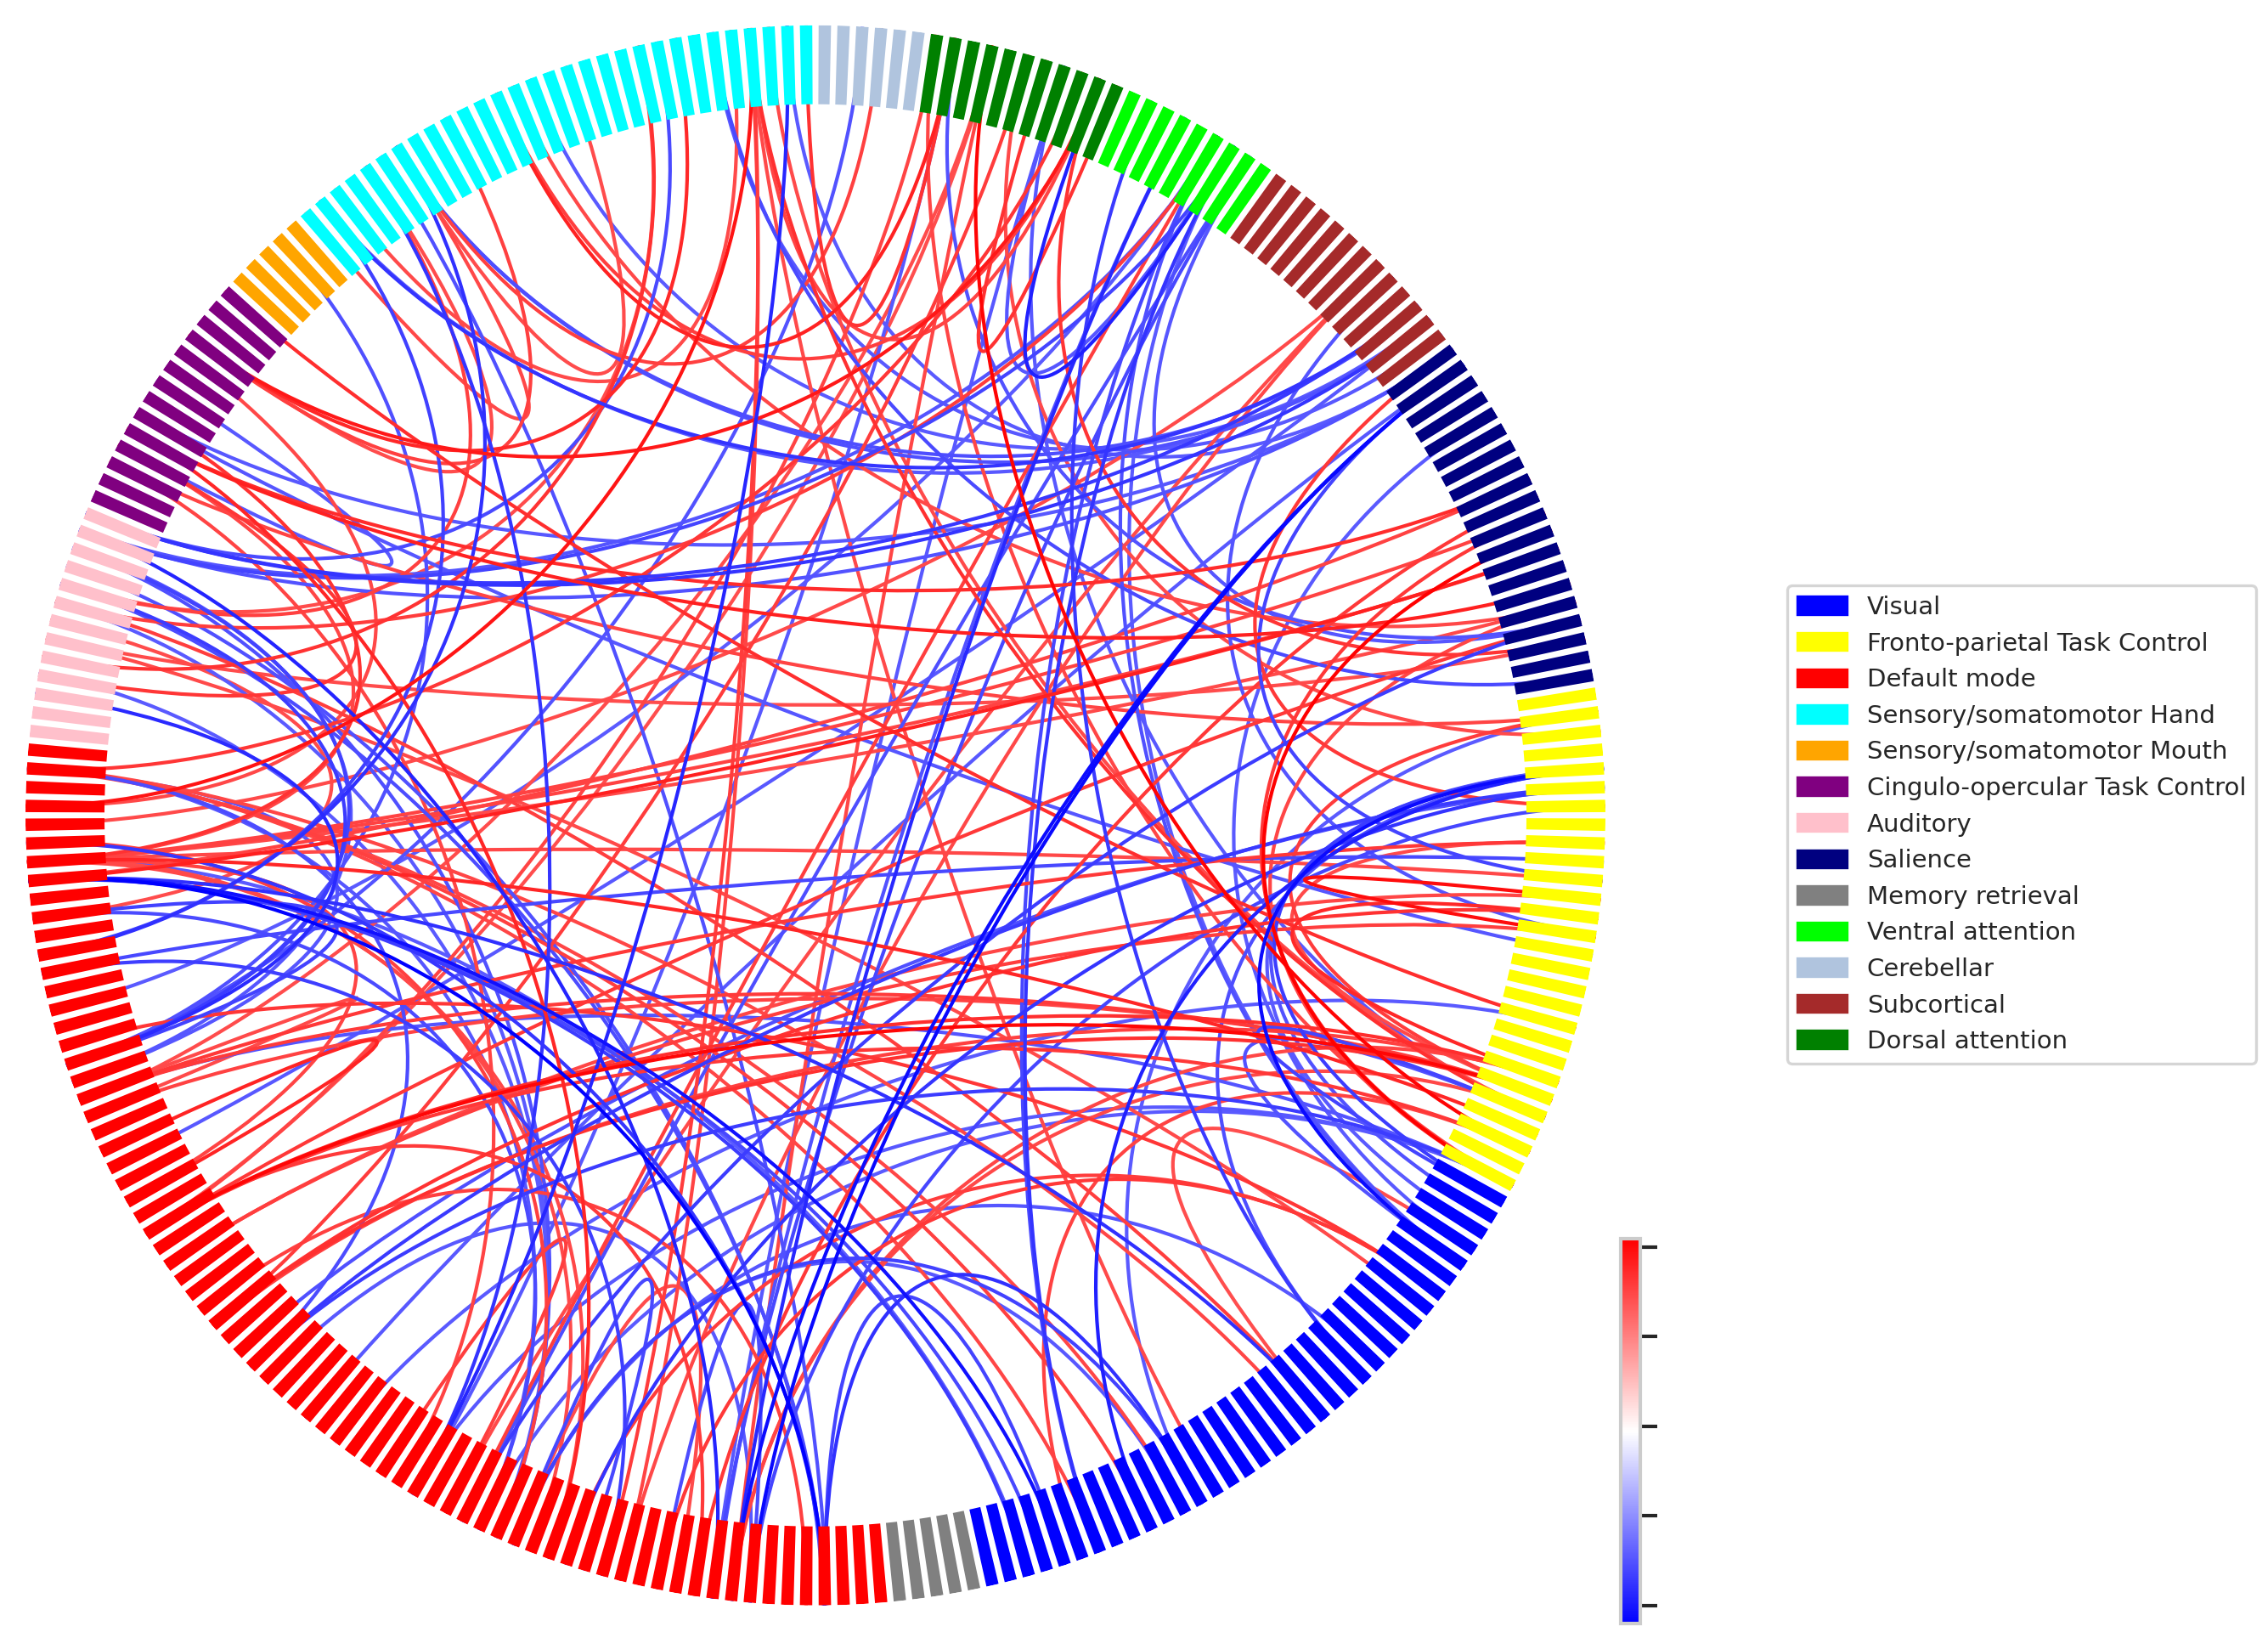

In [17]:
power_legend_patches = get_power_mpl_legend()
matrix = to_power_fc_matrix(selected_features)

plt.rc('legend',fontsize=7)
fig = plt.figure(figsize=(10, 10), facecolor=(0, 0, 0, 0))
fig.legend(handles=power_legend_patches, loc="center right")
node_names = ["" for node_num in range(1, 265)]

fig, ax = plot_connectivity_circle(
    matrix, node_names, n_lines=200, node_angles=node_angles, fontsize_names=4, padding=0, 
    colormap='bwr', linewidth=1, show=True, node_colors=node_colors, facecolor=(0, 0, 0, 0), 
    node_edgecolor=(0, 0, 0, 0), colorbar=True, node_width=0.9, fig=fig)

## Plot connectivity circle (by network)

In [123]:
from os.path import join

from common.paths import RIDGE_WEIGHT_IMGS
from common.plotting import (get_positive_connections, get_negative_connections, 
                             plot_circular_graph)
from common.power_atlas import (POWER_LABELS, to_power_fc_matrix, to_power_network_fc_vector,
                                to_power_network_fc_matrix, get_power_fc_vector_labels,
                                select_k_connections)

mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['savefig.pad_inches'] = 0.1
mpl.rcParams['savefig.facecolor'] = 'white'
mpl.rcParams['savefig.bbox'] = 'tight'

### Plot mean per network

In [136]:
# fc_matrix = to_power_network_fc_matrix(to_power_network_fc_vector(selected_features))
# fc_matrix = np.abs(fc_matrix)
fc_vector = to_power_network_fc_vector(selected_features)
fc_matrix = to_power_network_fc_matrix(select_k_connections(np.abs(fc_vector), mode='bottom'))

fc_matrix_pos = get_positive_connections(fc_matrix)
fc_matrix_neg = get_negative_connections(fc_matrix)

print(fc_matrix_pos.shape, fc_matrix_neg.shape)
print(np.min(fc_matrix), np.max(fc_matrix))
title = f'Mean per network ({model}, {population}, {selected_target}, {age_group})'

(13, 13) (13, 13)
1.5531506505794823e-05 0.005311356391757727


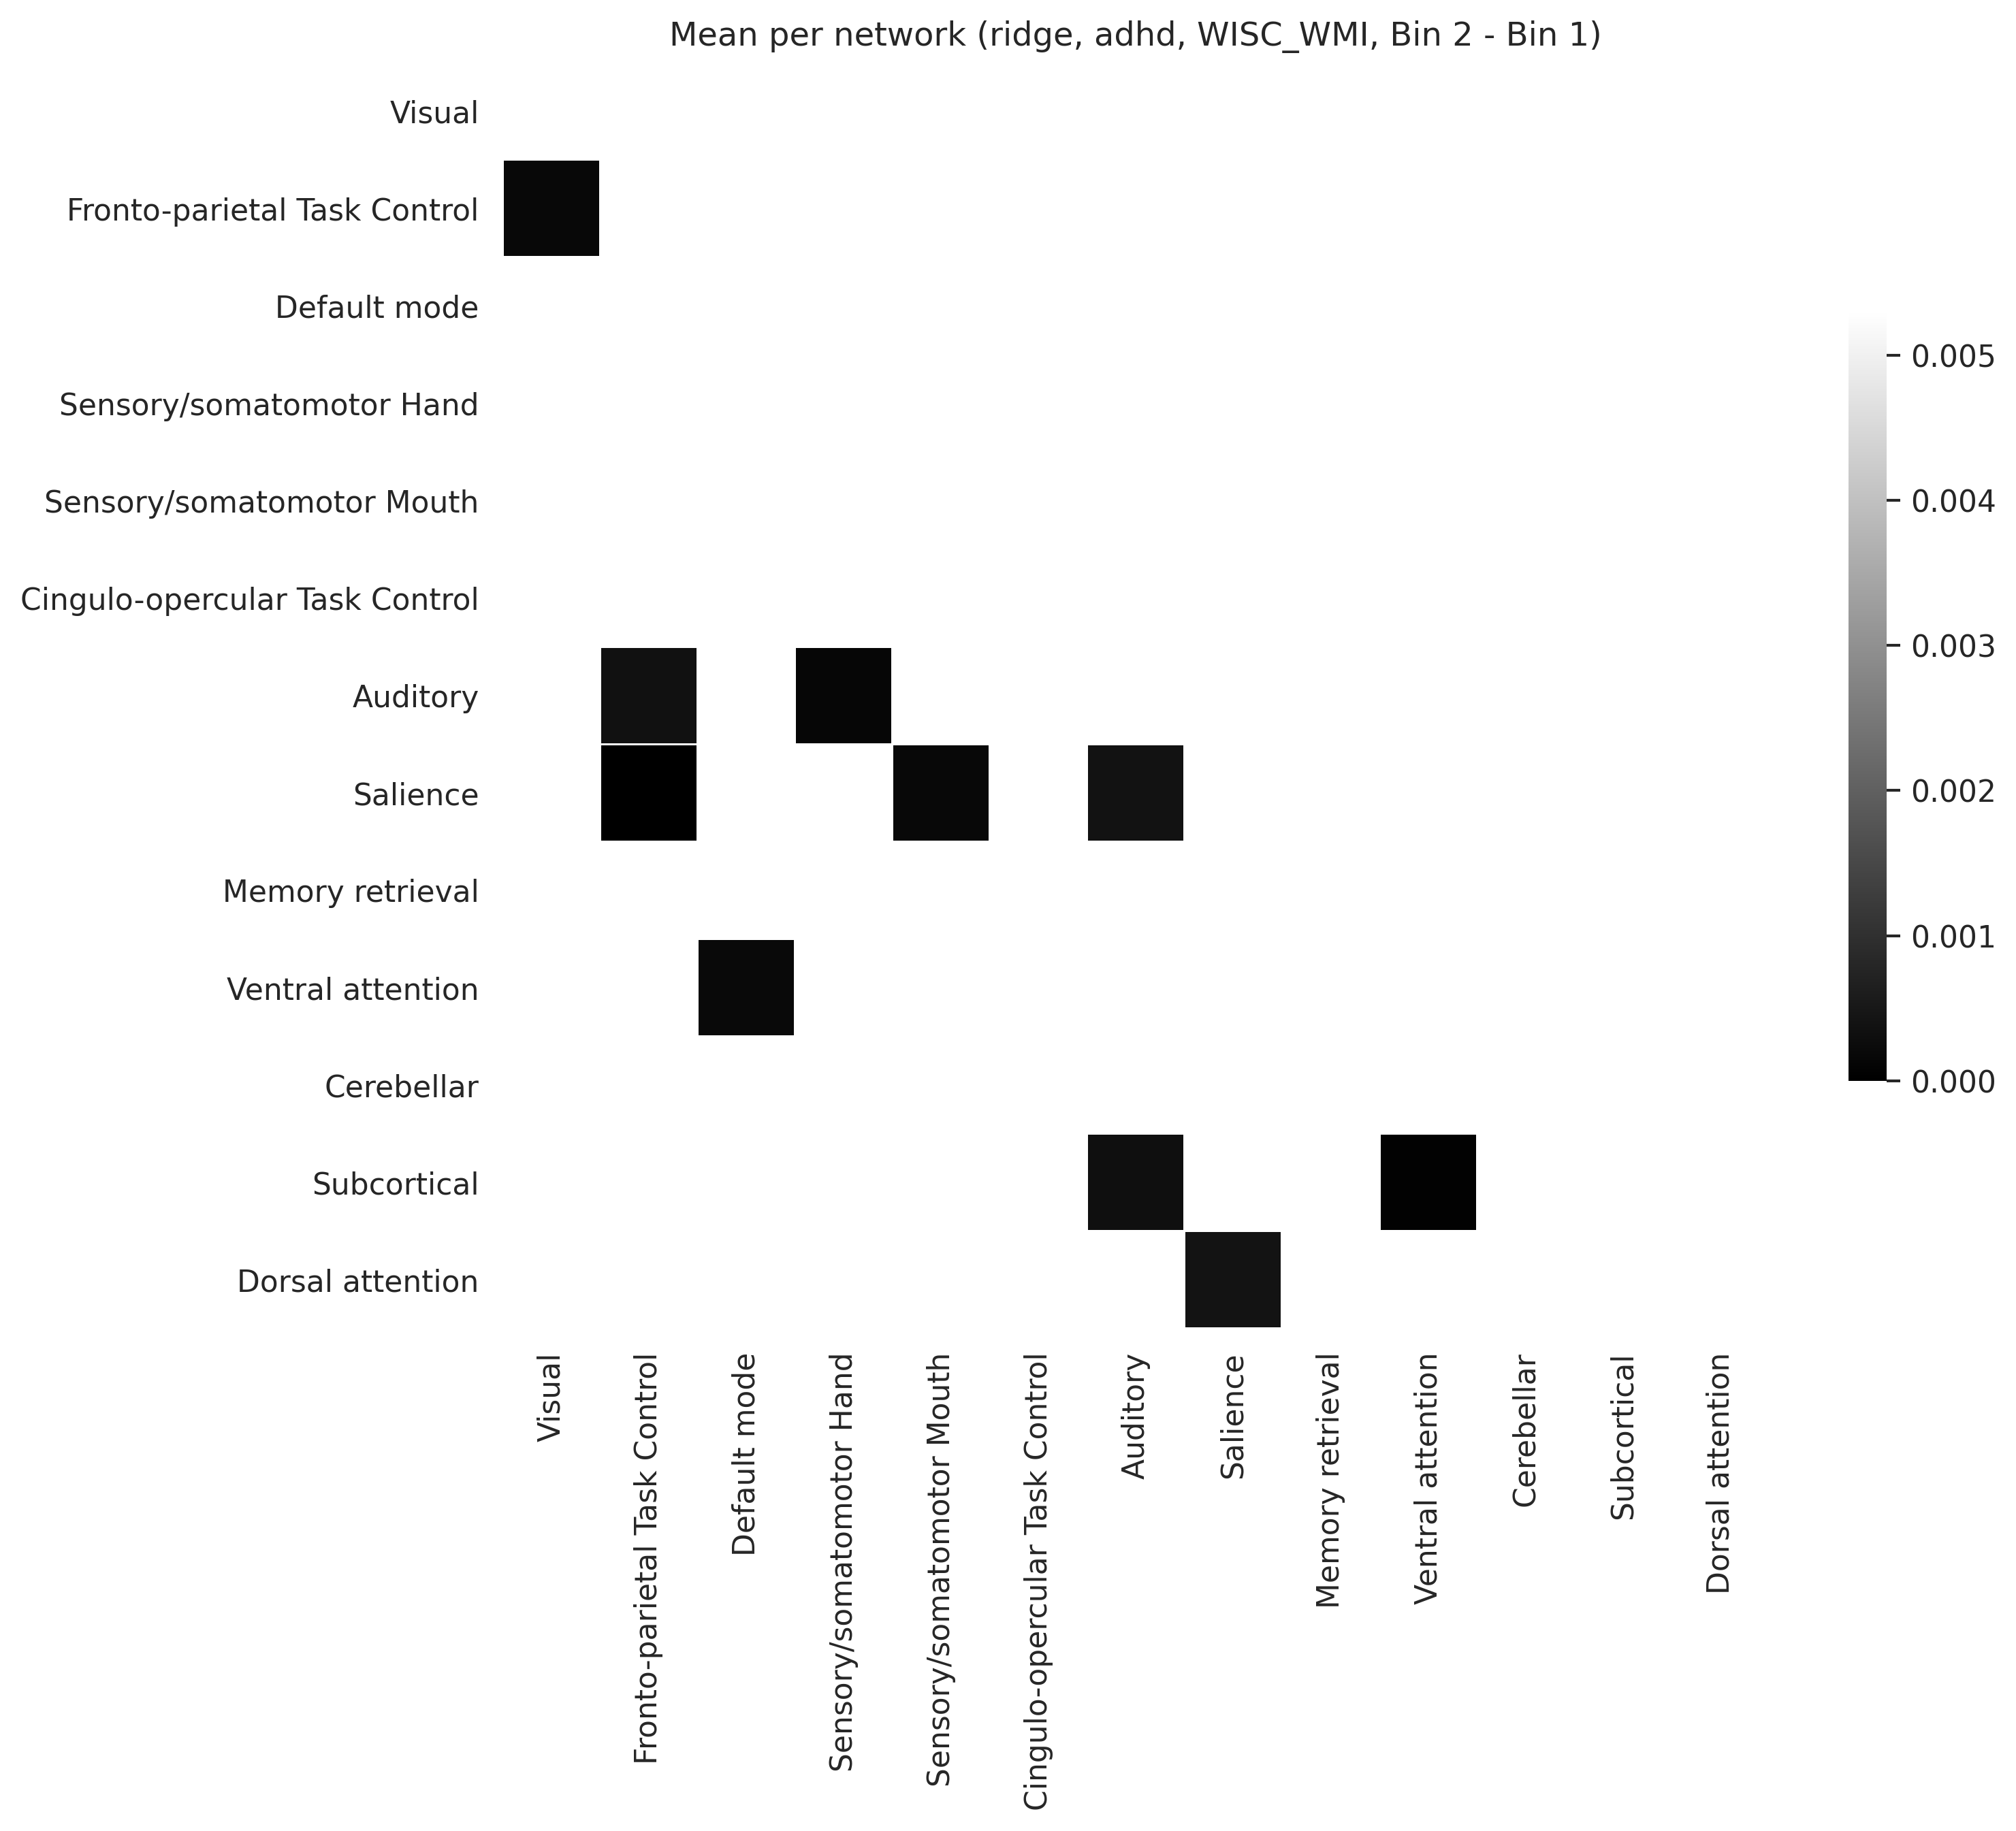

In [137]:
from common.power_atlas import POWER_LEGEND

mask = np.zeros_like(fc_matrix)
mask[np.triu_indices_from(mask, k=1)] = True
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_title(title)
# ax = sns.heatmap(fc_matrix, cmap=cmap, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=POWER_LEGEND.values(),
#             xticklabels=POWER_LEGEND.values(), mask=mask, vmin=-cbar_max_neg[selected_target], 
#             vmax=cbar_max_pos[selected_target], ax=ax)
# fig.savefig(join(RIDGE_WEIGHT_IMGS, age_group, selected_target, f'{model}_{population}_{selected_target}_{age_group}_matrix.svg'), 
#             format='svg')
ax = sns.heatmap(fc_matrix, cmap='binary_r', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=POWER_LEGEND.values(),
            xticklabels=POWER_LEGEND.values(), mask=mask, ax=ax, vmin=0)
fig.savefig(join(RIDGE_WEIGHT_IMGS, 'Bin Similarities', selected_target, f'{model}_{population}_{selected_target}_{age_group}_matrix_bottom_ten.svg'), 
            format='svg')
plt.show()
plt.close(fig)

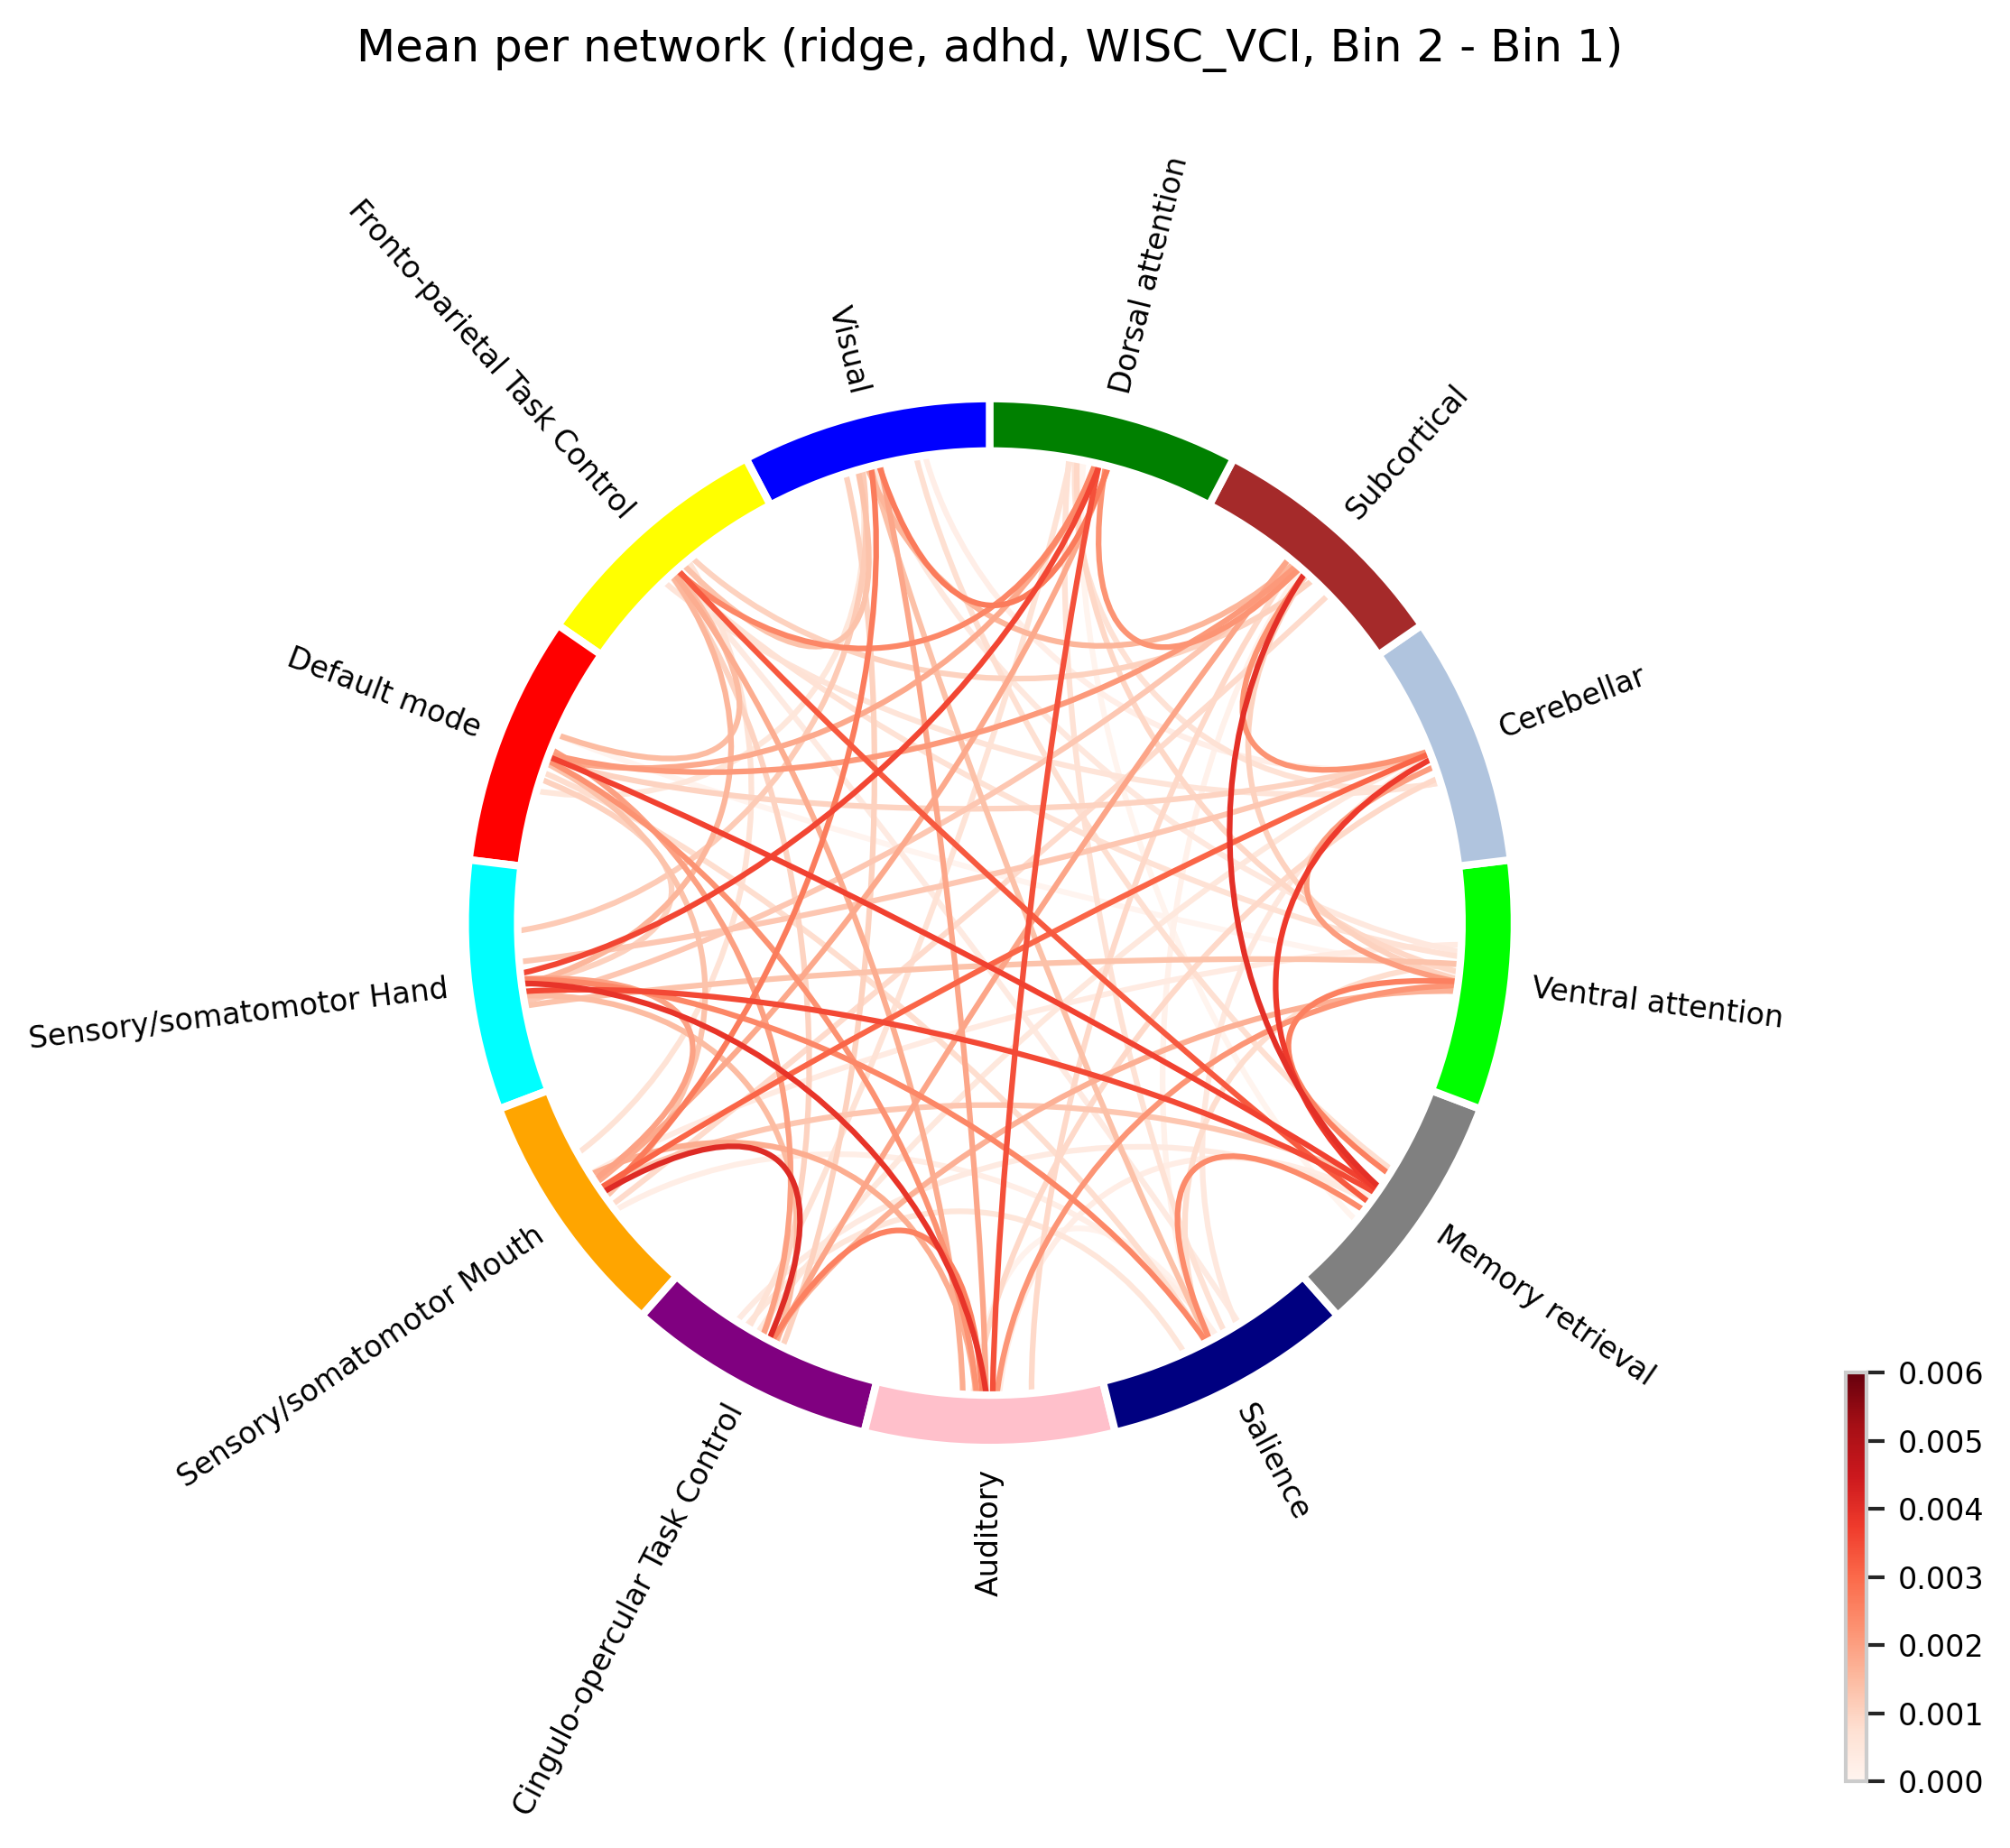

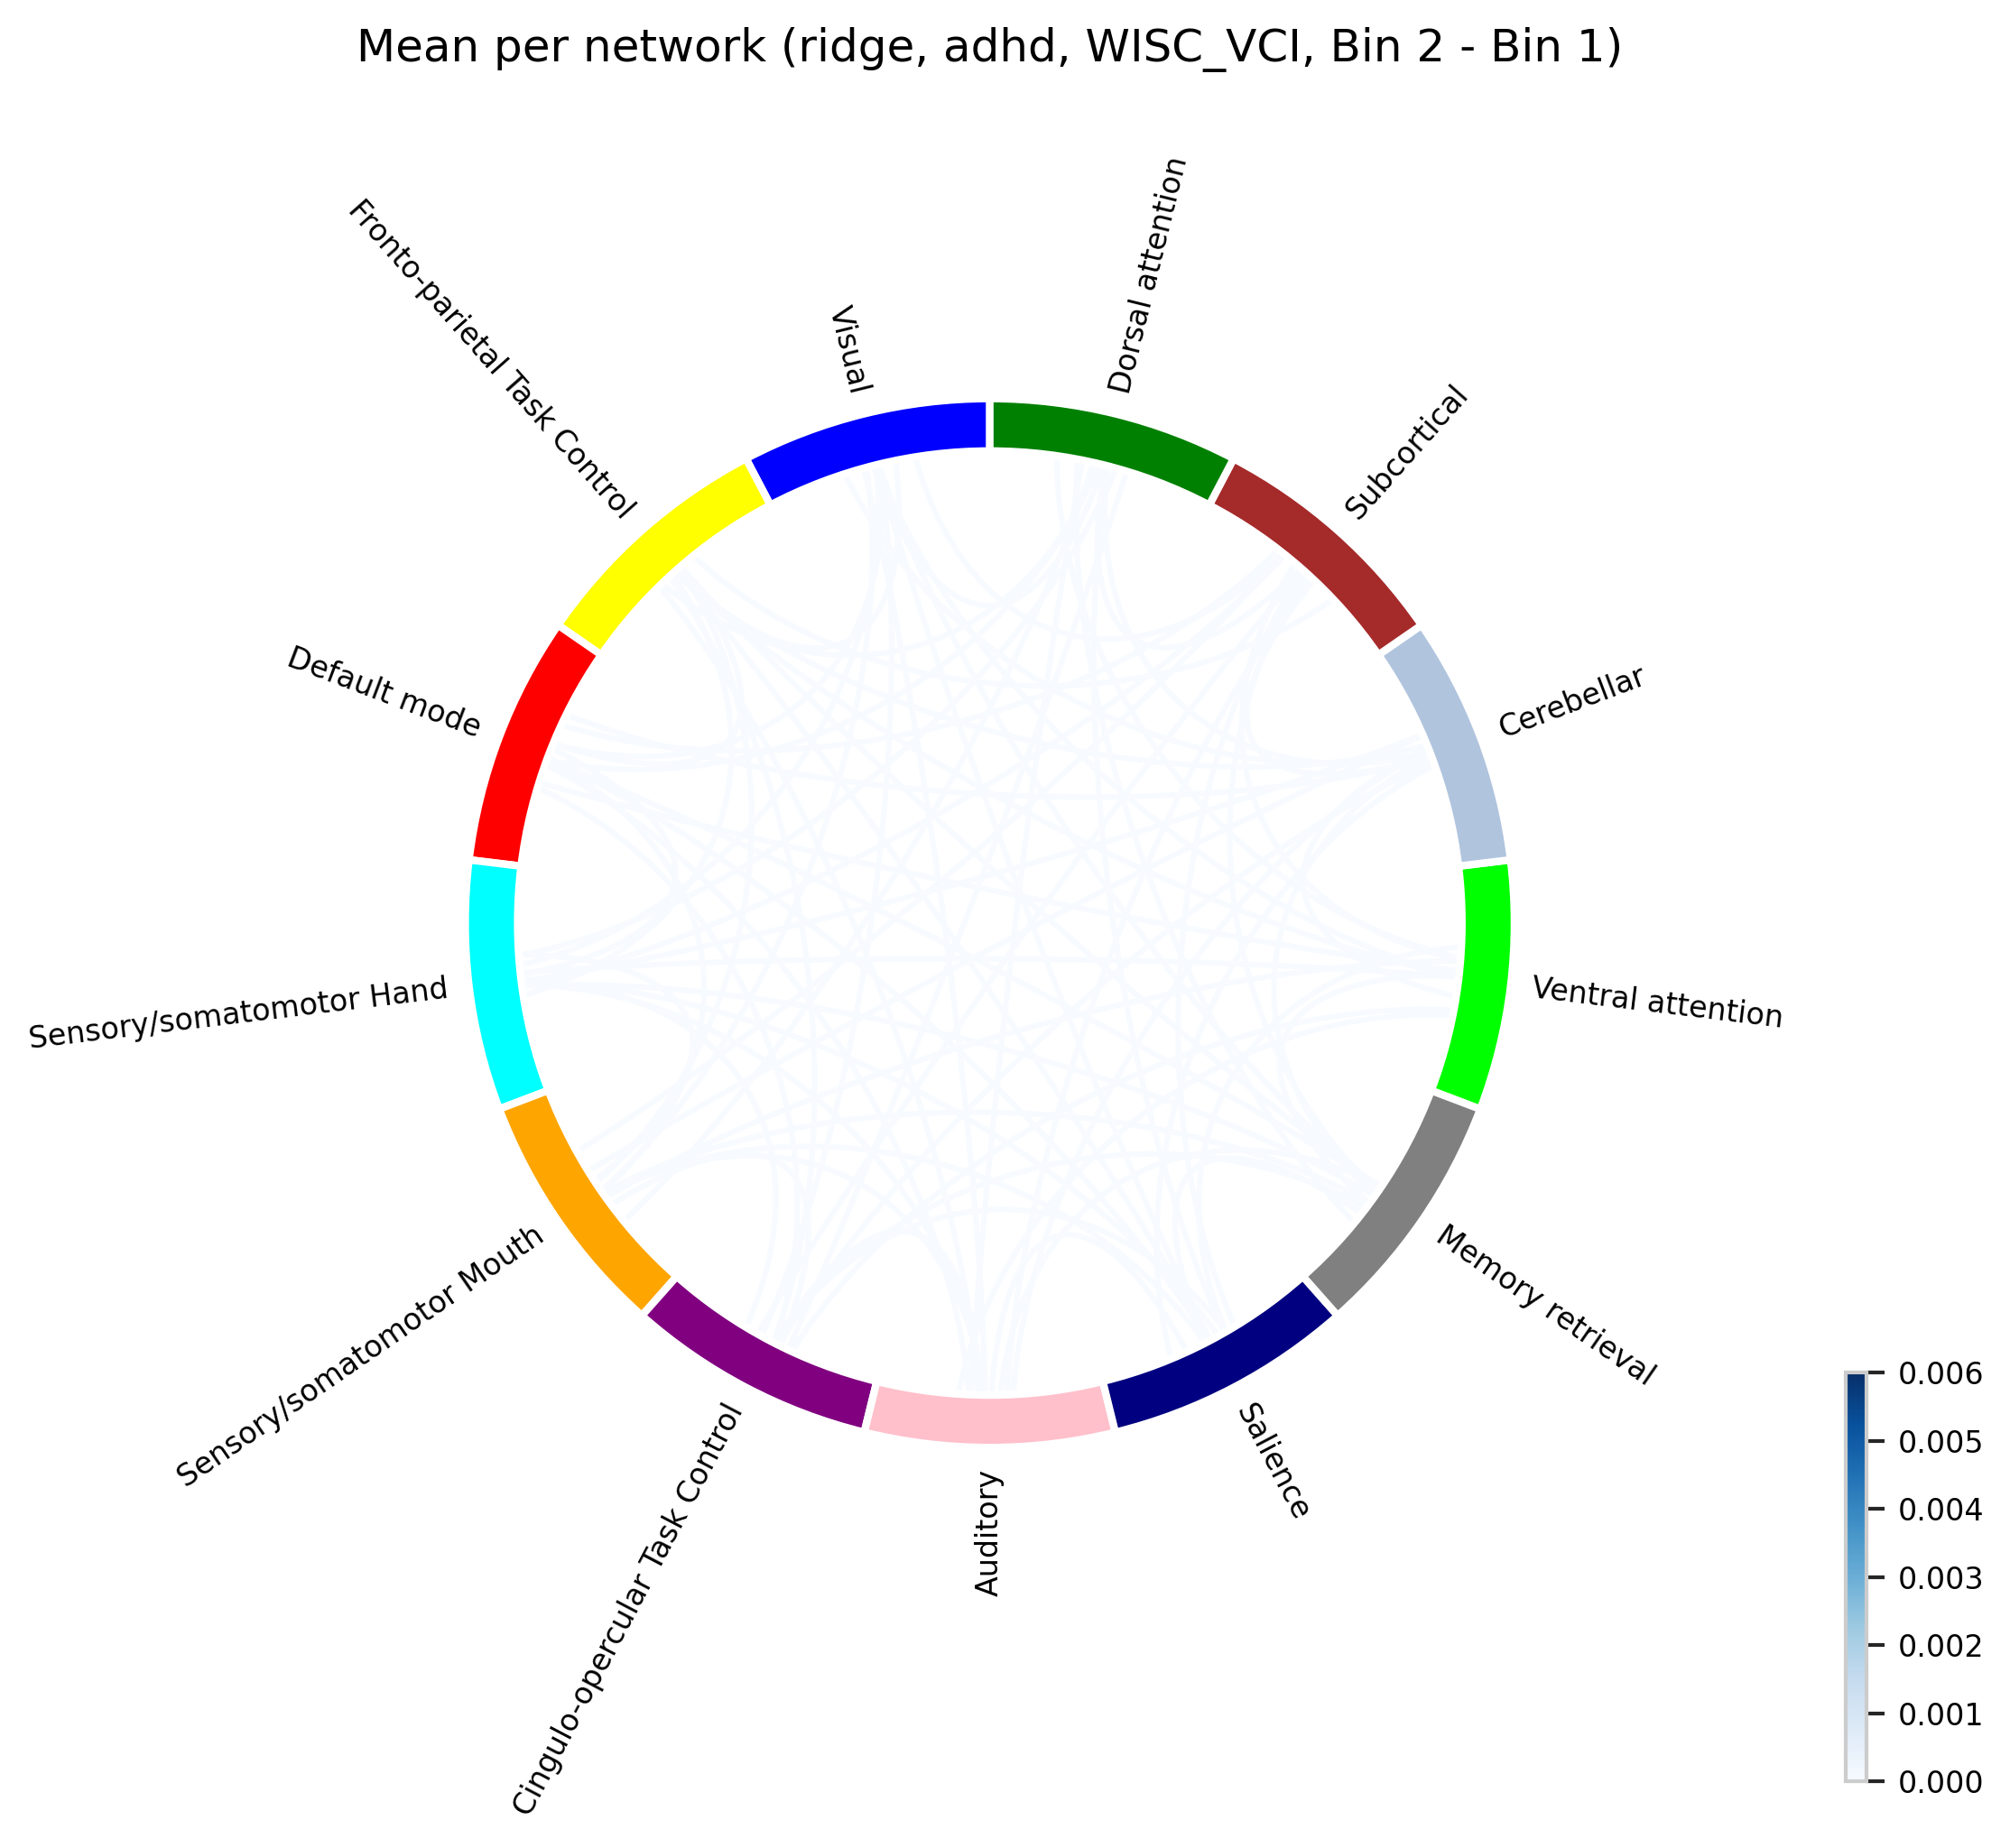

In [82]:
# Plot positive connections
fig = plt.figure(figsize=(10, 10), facecolor='white')
fig, ax = plot_circular_graph(fc_matrix_pos, title=title, sign='pos', vmin=0, vmax=cbar_max_pos[selected_target], fig=fig)
fig.savefig(join(RIDGE_WEIGHT_IMGS, age_group, selected_target, f'{model}_{population}_{selected_target}_{age_group}_cg_mean_pos.svg'),
            format='svg')

# Plot negative connections
fig = plt.figure(figsize=(10, 10), facecolor='white')
fig, ax = plot_circular_graph(-fc_matrix_neg, title=title, sign='neg', vmin=0, vmax=cbar_max_neg[selected_target], fig=fig)
fig.savefig(join(RIDGE_WEIGHT_IMGS, age_group, selected_target, f'{model}_{population}_{selected_target}_{age_group}_cg_mean_neg.svg'),
            format='svg')

### Plot sum of absolute value per network

In [113]:
# Aggregate all edges of each network based on sum of absolute value
network_abs_sum_weights = dict()
for k, v in network_weights.items():
    network_abs_sum_weights[k] = np.sum(np.absolute(v))

fc_matrix = to_power_network_fc_matrix(list(network_abs_sum_weights.values()))

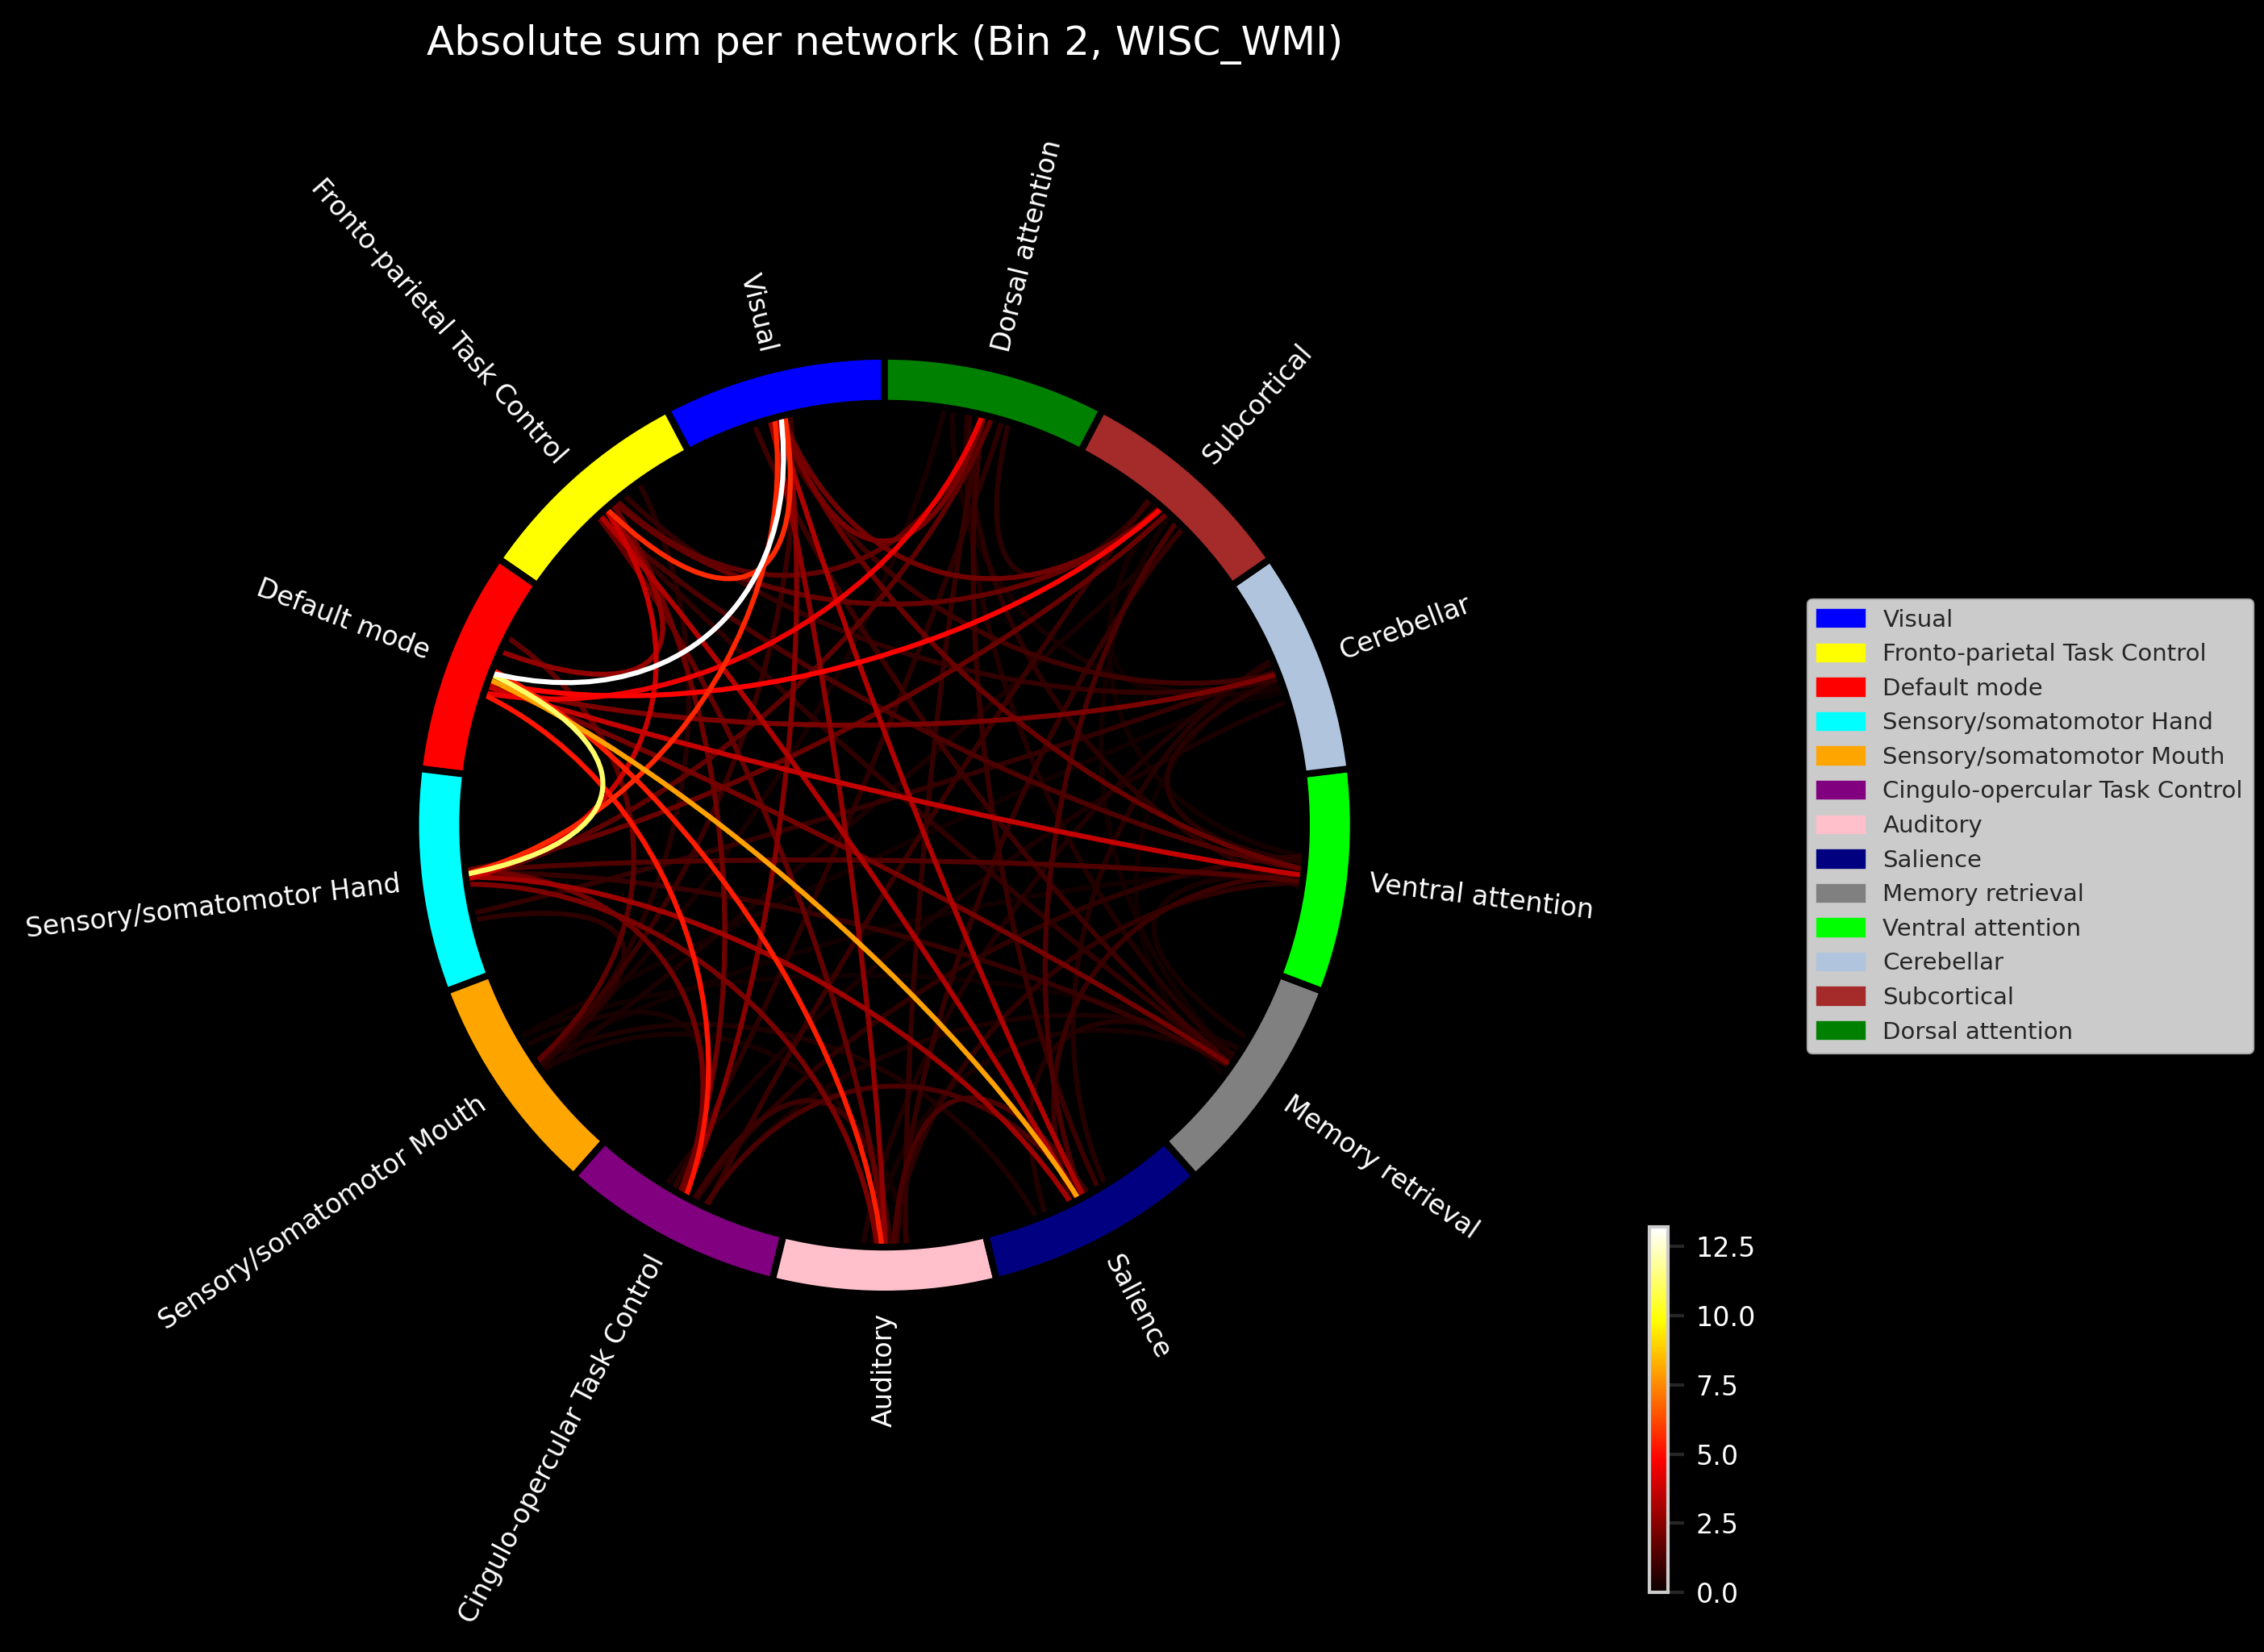

In [114]:
power_legend_patches = get_power_mpl_legend()

plt.rc('legend', fontsize=7)
fig = plt.figure(figsize=(10, 10), facecolor='black')
fig.legend(handles=power_legend_patches, loc="center right")

fig, ax = plot_connectivity_circle(
    fc_matrix, node_names, node_angles=node_angles, 
    show=True, node_colors=node_colors, facecolor='black', 
    textcolor='white', node_edgecolor='black', colorbar=True, fig=fig, 
    title=f'Absolute sum per network ({age_group}, {selected_target})', vmin=0)